This notebook helps with labeleing dyno cards. 

Data is imported from the table (a view) `xspoc.card_xdiag` as this contains merged info from tables `xspoc.xdiagresults` and `xspoc.card`

Following are the columns from each table:
- dyna.card
    - pocdowncard
    - surfcard
    - SPM
    - Fillage

- dyna.xdiagresults
    - xlabel1
    - xlabel2
    
*Note: If other columns are needed, notify the database manager to include those columns in the view xspoc.card_xdiag*

In [2]:
"""
For setting up local imports in an Ipython Shell
This is a workaround for ipython, dont need it for basic python scripts
"""
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [38]:
import pandas as pd
import numpy as np
import struct
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon
from shapely.wkb import loads, dumps

# Project Library
from library.lib_aws import PostgresRDS
from library import lib_dyna, lib_aws, lib_visual

## Saving the files for labelling

In [42]:
"""
Query the specific data for a well
Note: xspoc.card_xdiag is db schema
"""

database = 'oasis-dev'  # Dtabase to use

well_name = 'Johnsrud 5198 14-18 11T'
# Modify the query to get needed columns
query = """
SELECT 
* 
FROM xspoc.card_xdiag
WHERE "NodeID" = '{}'
""".format(well_name)

with lib_aws.PostgresRDS(db=database) as engine:
    data = pd.read_sql(query, engine, parse_dates="Date")

data.fillna(np.nan, inplace=True)
data.head()

Connected to oasis-dev DataBase
Connection Closed


,NodeID,Date,downcard,surfcard,SPM,Fillage,xlabel1,xlabel2
0,Johnsrud 5198 14-18 11T,2019-03-19 02:49:50,01030000000100000064000000000000C01E850F400000...,010300000001000000C8000000000000C0F528E43F0000...,1.4,49.3,NaN,NaN
1,Johnsrud 5198 14-18 11T,2019-03-19 02:57:30,01030000000100000064000000000000E051B8EE3F0000...,010300000001000000C8000000000000A0703DDA3F0000...,2.8,63.0,NaN,NaN
2,Johnsrud 5198 14-18 11T,2019-03-20 03:19:45,010300000001000000640000000000000000000A400000...,010300000001000000C800000000000040E17AE43F0000...,1.4,49.9,NaN,NaN
3,Johnsrud 5198 14-18 11T,2019-03-20 03:26:41,0103000000010000006400000000000080EB51D83F0000...,010300000001000000C8000000000000A09999D93F0000...,2.8,60.8,NaN,NaN
4,Johnsrud 5198 14-18 11T,2019-03-20 06:39:06,01030000000100000064000000000000E07A1412400000...,010300000001000000C8000000000000C0F528E43F0000...,1.4,49.3,NaN,NaN


In [43]:
# Convertinf card cols from wkb into a shapely polygon obj
card_cols = ['downcard', 'surfcard']

for c in card_cols:
    data.loc[:, c] = data.loc[:, c].apply(lambda x: loads(x, hex=True))
    
data.head()

,NodeID,Date,downcard,surfcard,SPM,Fillage,xlabel1,xlabel2
0,Johnsrud 5198 14-18 11T,2019-03-19 02:49:50,"POLYGON ((3.940000057220459 -7971, 12.38000011...","POLYGON ((0.6299999952316284 21902, 1.26999998...",1.4,49.3,NaN,NaN
1,Johnsrud 5198 14-18 11T,2019-03-19 02:57:30,"POLYGON ((0.9599999785423279 -7748, 4.19000005...","POLYGON ((0.4099999964237213 22083, 0.80000001...",2.8,63.0,NaN,NaN
2,Johnsrud 5198 14-18 11T,2019-03-20 03:19:45,"POLYGON ((3.25 -8300, 11.36999988555908 -8625,...","POLYGON ((0.6399999856948853 21502, 1.26999998...",1.4,49.9,NaN,NaN
3,Johnsrud 5198 14-18 11T,2019-03-20 03:26:41,"POLYGON ((0.3799999952316284 -7849, 3.27999997...","POLYGON ((0.4000000059604645 21809, 0.80000001...",2.8,60.8,NaN,NaN
4,Johnsrud 5198 14-18 11T,2019-03-20 06:39:06,"POLYGON ((4.519999980926514 -7841, 13.59000015...","POLYGON ((0.6299999952316284 22390, 1.26999998...",1.4,49.3,NaN,NaN


In [44]:
"""
Run the remove errors method from 
lib_dyna.MultiLabels class to 
- remove erros from a dynamometer card col
- get an idea of the labels
"""

mlabels = lib_dyna.MultiLabels(df=data,
                                well_col='NodeID',
                                card_col='downcard', # Downcard is being checked 
                                label_cols=['xlabel1', 'xlabel2'])  

mlabels.remove_errors()
mlabels.merge_labels()  # merge labels
display(mlabels.get_group_counts())  # Get label gp counts
display(mlabels.get_label_counts())  # Get singualar label counts

data = mlabels.df  # replace data with the clean data

del mlabels # delete the class intance, will help save memory if needed

,xlabel1,xlabel2,totalVal,pctVal
0,Gas interference,NA,1162,32.02
1,Gas interference,High rod-tubing friction,999,27.53
2,NA,NA,954,26.29
3,High rod-tubing friction,Incomplete pump fillage,181,4.99
4,Incomplete pump fillage,NA,145,4.00
5,Full pump,NA,121,3.33
6,Gas interference,Worn pump barrel,18,0.50
7,Fluid pound,NA,15,0.41
8,Bent pump barrel or sticking plunger,Gas interference,6,0.17
9,High rod-tubing friction,Worn pump barrel,6,0.17


,totalVal,pctVal
Gas interference,2194,60.457
High rod-tubing friction,1188,32.736
Incomplete pump fillage,333,9.176
Full pump,121,3.334
Worn pump barrel,29,0.799
Fluid pound,17,0.468
Bent pump barrel or sticking plunger,12,0.331
Phase shift in dyno card,4,0.110
Pump hitting down,2,0.055
Pump hitting up,2,0.055


NodeID                                Johnsrud 5198 14-18 11T
Date                                      2019-03-27 04:40:10
downcard    POLYGON ((2.009999990463257 -7150, 7.440000057...
surfcard    POLYGON ((0.3899999856948853 23466, 0.80000001...
SPM                                                       2.8
Fillage                                                    59
xlabel1                                                   NaN
xlabel2                                                   NaN
Name: 112, dtype: object


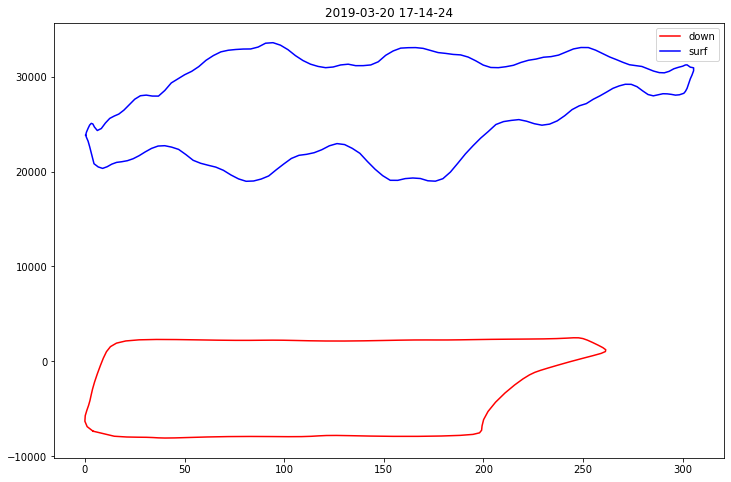

In [45]:
"""
Save and/or plot the cards
Use: lib_visual.dyna_plot()
"""
# Test the dyna plot method
index = 11
card_cols = ['downcard', 'surfcard']  # select the geometry to plot
well, date= data.loc[index, ['NodeID', 'Date']]

cards = data.loc[index, card_cols].to_list()

print(data.loc[112])

name = date.strftime('%Y-%m-%d %H-%M-%S')
lib_visual.dyna_plot(cards, name, set_axis=None, color=['r', 'b', 'g'], save=None, show=True, fig_labels = ['down', 'surf', 'pred'], legend=True)

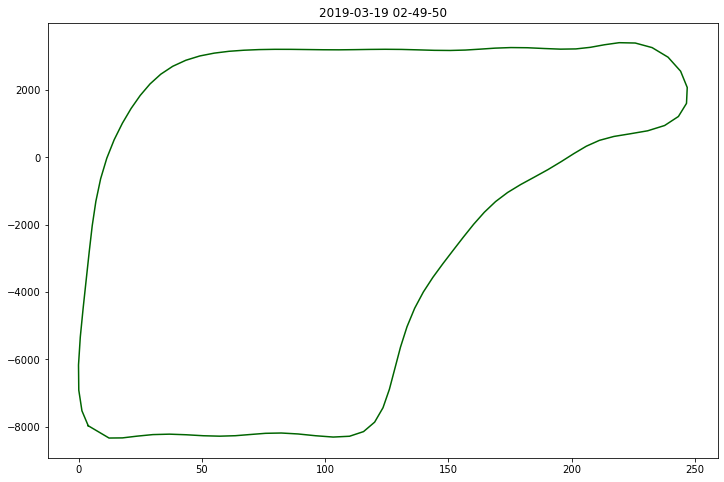

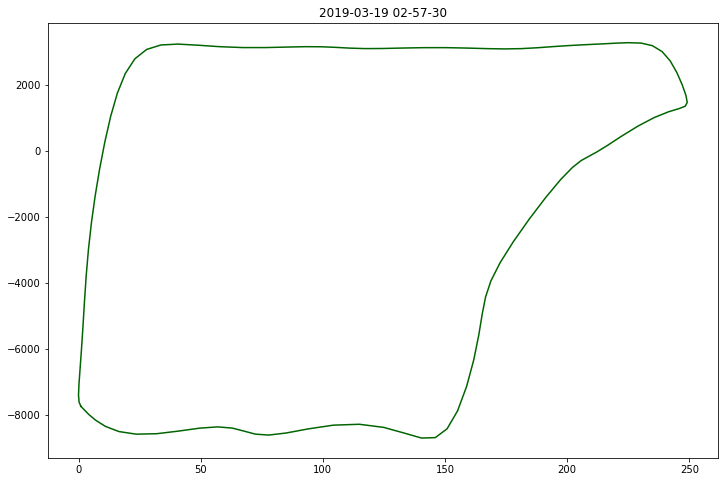

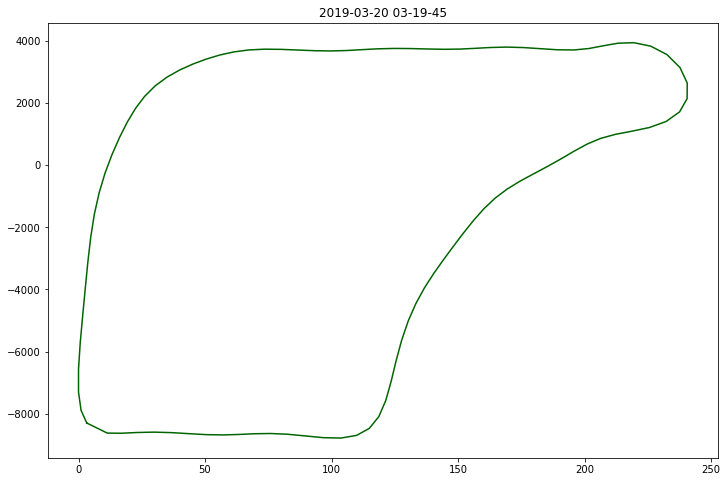

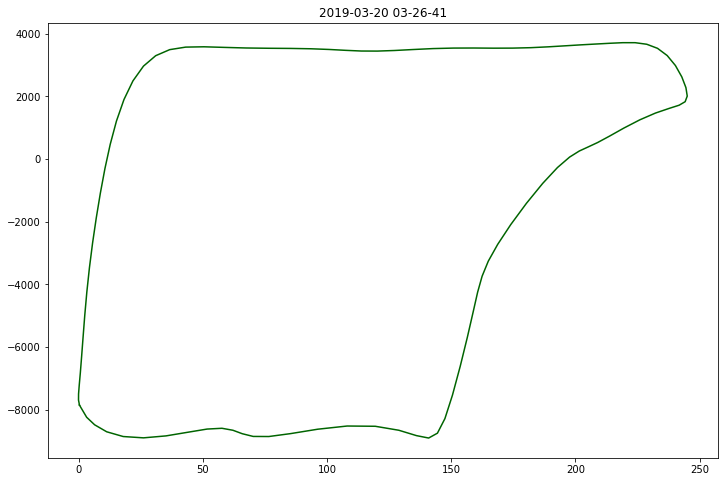

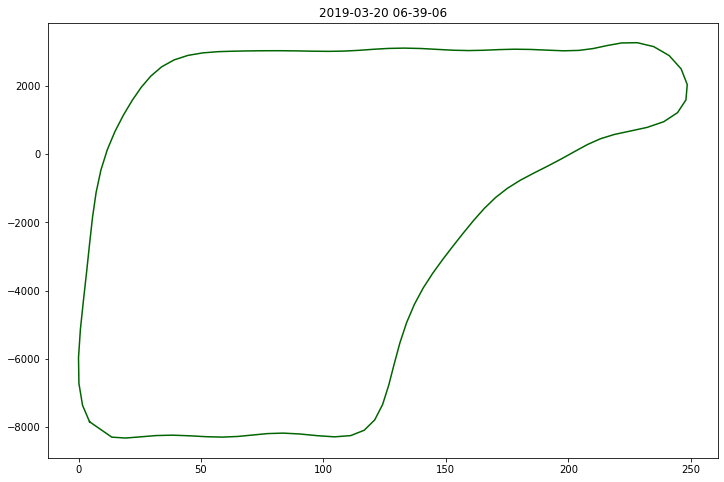

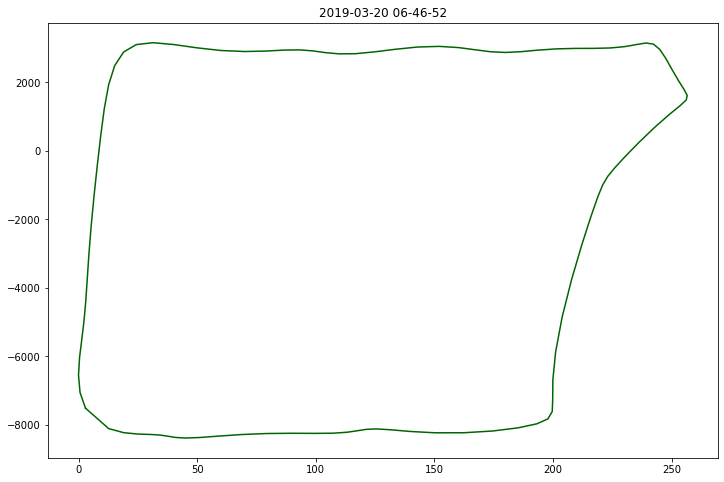

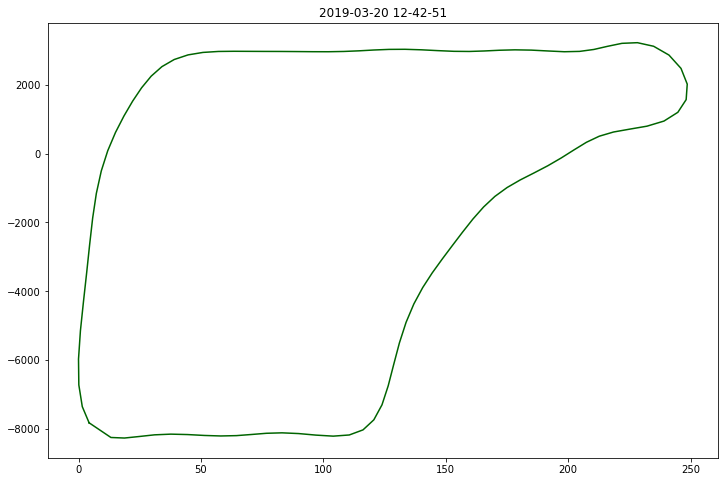

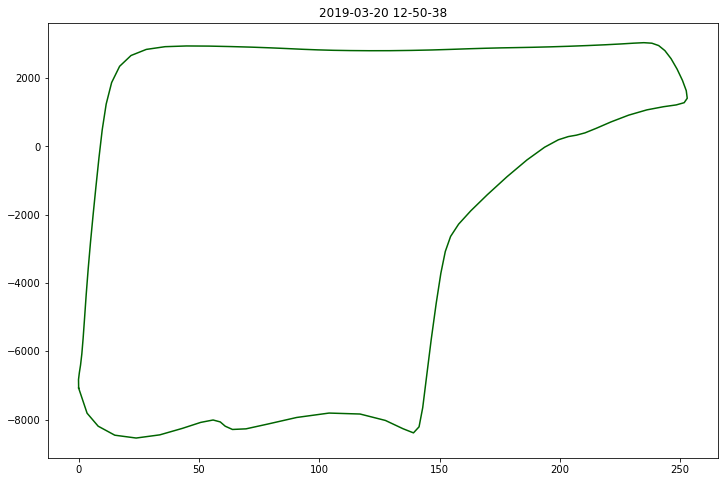

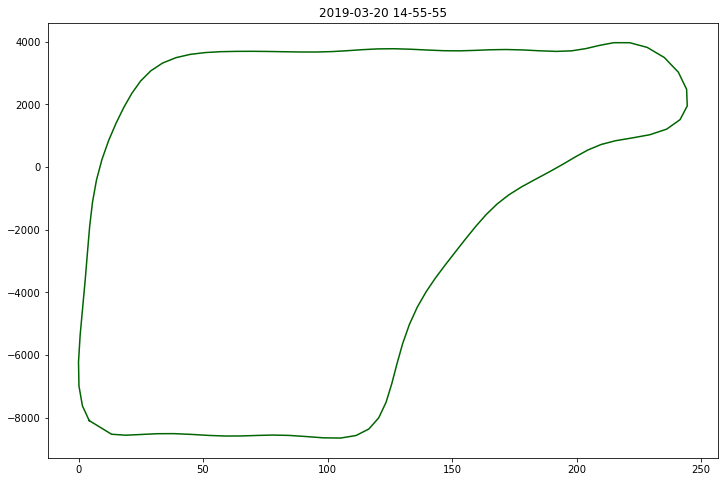

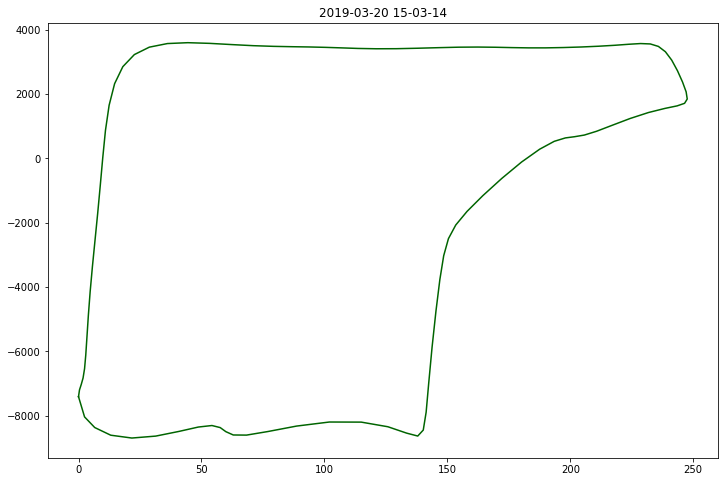

In [31]:
"""
Save
"""

save_path = r"/path"
card_cols = ['downcard']  # Select the geometry column

for i in data.index[0:10]:
    well, date = data.loc[i, ['NodeID', 'Date']]
    cards = data.loc[i, card_cols].to_list()
    date = pd.to_datetime(str(date))
    name = date.strftime('%Y-%m-%d %H-%M-%S')
    
    lib_visual.dyna_plot(cards, name, fill=False, color=['DARKGREEN'], set_axis=None, save=save_path, show=False, legend=False) 

In [47]:
"""
Save the dataframe without any TrueLabels
"""
convert to wkb format
card_cols = ['downcard', 'surfcard',]
for c in card_cols:
    data.loc[:, c] = data.loc[:, c].apply(lambda x: dumps(x, hex=True))

display(data.head())

data.set_index('Date').to_csv('dataname.csv')

,NodeID,Date,downcard,surfcard,SPM,Fillage,xlabel1,xlabel2
0,Johnsrud 5198 14-18 11T,2019-03-19 02:49:50,01030000000100000064000000000000C01E850F400000...,010300000001000000C8000000000000C0F528E43F0000...,1.4,49.3,NaN,NaN
1,Johnsrud 5198 14-18 11T,2019-03-19 02:57:30,01030000000100000064000000000000E051B8EE3F0000...,010300000001000000C8000000000000A0703DDA3F0000...,2.8,63.0,NaN,NaN
2,Johnsrud 5198 14-18 11T,2019-03-20 03:19:45,010300000001000000640000000000000000000A400000...,010300000001000000C800000000000040E17AE43F0000...,1.4,49.9,NaN,NaN
3,Johnsrud 5198 14-18 11T,2019-03-20 03:26:41,0103000000010000006400000000000080EB51D83F0000...,010300000001000000C8000000000000A09999D93F0000...,2.8,60.8,NaN,NaN
4,Johnsrud 5198 14-18 11T,2019-03-20 06:39:06,01030000000100000064000000000000E07A1412400000...,010300000001000000C8000000000000C0F528E43F0000...,1.4,49.3,NaN,NaN


# Using Partly Labeled Data to label the entire dataset

In [74]:
"""
Import the partially labeled data
"""

pdata = pd.read_csv("dataname.csv", parse_dates=['Date'])
display(pdata.head())

,Date,NodeID,downcard,surfcard,SPM,Fillage,xlabel1,xlabel2
0,2019-03-19 02:49:50,Johnsrud 5198 14-18 11T,01030000000100000064000000000000C01E850F400000...,010300000001000000C8000000000000C0F528E43F0000...,1.4,49.3,NaN,NaN
1,2019-03-19 02:57:30,Johnsrud 5198 14-18 11T,01030000000100000064000000000000E051B8EE3F0000...,010300000001000000C8000000000000A0703DDA3F0000...,2.8,63.0,NaN,NaN
2,2019-03-20 03:19:45,Johnsrud 5198 14-18 11T,010300000001000000640000000000000000000A400000...,010300000001000000C800000000000040E17AE43F0000...,1.4,49.9,NaN,NaN
3,2019-03-20 03:26:41,Johnsrud 5198 14-18 11T,0103000000010000006400000000000080EB51D83F0000...,010300000001000000C8000000000000A09999D93F0000...,2.8,60.8,NaN,NaN
4,2019-03-20 06:39:06,Johnsrud 5198 14-18 11T,01030000000100000064000000000000E07A1412400000...,010300000001000000C8000000000000C0F528E43F0000...,1.4,49.3,NaN,NaN


In [75]:
"""
Config
"""
card_col = 'pocdowncard'  # Card for features
label_cols = ['xlabel1', 'xlabel2']  # labels being predicted

In [76]:
"""
Well Bounds for normalizing
"""
# Get well bounds for normalizing
lb = lib_dyna.CardFunctions(df=pdata,
                           card_col=card_col,
                           well_col='NodeID')
lb.remove_errors()
bounds_df = lb.all_bounds()
pdata = lb.df
del lb
display(bounds_df)

,Johnsrud 5198 14-18 11T
pos_min,0.000000
pos_max,296.959991
load_min,-9897.000000
load_max,6149.000000


In [101]:
"""
Split into Train and Test
Train where labels are present (label1 should be atleast present)
"""

# Test Data
test_data = pdata[pdata.loc[:, label_cols[0]].isnull()]
test_data.loc[:, card_col] = test_data.loc[:, card_col].apply(lambda x: loads(x, hex=True))
test_data.reset_index(inplace=True, drop=True)

# Train data
train_data = pdata[~pdata.loc[:, label_cols[0]].isnull()]
train_data.loc[:, card_col] = train_data.loc[:, card_col].apply(lambda x: loads(x, hex=True))
train_data.reset_index(inplace=True, drop=True)


print("Train data shape: {}\nTest data shape: {}".format(train_data.shape[0], test_data.shape[0]))

Train data shape: 2675
Test data shape: 954


In [138]:
# bounds_df

# bounds_static = [0, 100, -1000, 500]
# fea_train.get_X(fd_order=5, area=True, centroid=True, normalize_fn='static', norm_arg=bounds_static)

# # card specific
# # card normalizes


,Johnsrud 5198 14-18 11T
pos_min,0.000000
pos_max,296.959991
load_min,-9897.000000
load_max,6149.000000


In [102]:
"""
Get Features
Use the class lib_dyna.Features
"""
# Training features
fea_train = lib_dyna.Features(df=train_data,
                             card_col=card_col,
                             well_col='NodeID',
                             label_cols=label_cols)

fea_train.merge_labels()
display(fea_train.get_group_counts())  # Get label gp counts
x_train = fea_train.get_X(fd_order=5, area=True, centroid=True, normalize_fn='df', norm_arg=bounds_df)
y_train, binarizer = fea_train.get_Y()  # Get y and binarizer

,xlabel1,xlabel2,totalVal,pctVal
0,Gas interference,NA,1162,43.44
1,Gas interference,High rod-tubing friction,999,37.35
2,High rod-tubing friction,Incomplete pump fillage,181,6.77
3,Incomplete pump fillage,NA,145,5.42
4,Full pump,NA,121,4.52
5,Gas interference,Worn pump barrel,18,0.67
6,Fluid pound,NA,15,0.56
7,Bent pump barrel or sticking plunger,Gas interference,6,0.22
8,High rod-tubing friction,Worn pump barrel,6,0.22
9,Bent pump barrel or sticking plunger,Incomplete pump fillage,5,0.19


In [107]:
# Test Features
fea_test = lib_dyna.Features(df=test_data,
                            card_col=card_col,
                            well_col='NodeID')

x_test = fea_test.get_X(fd_order=5, area=True, centroid=True, normalize_fn='df', norm_arg=bounds_df)

### Build a classification Model

In [110]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

In [111]:
def train_rfc(x, y):
    rfc_params = {
        'n_estimators': 100,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': 'auto',
        'max_depth': None,
        'class_weight': 'balanced',
        'bootstrap': False
    }

    rfc = RandomForestClassifier(**rfc_params)
    model = OneVsRestClassifier(rfc)
    print("Training the model")
    model.fit(x, y)
    print("Training done")

    return model

In [112]:
trained_model = train_rfc(x_train, y_train)

Training the model
Training done


In [136]:
"""
Predictions
"""

pred = lib_dyna.Predictions_MultiLabel(model=trained_model,
                                       x=x_test,
                                       mlb=binarizer)

pred_data = pred.get_pred_df(n=2)
full_pred = pd.concat([fea_test.df, pred_data], axis=1)
full_pred.head()

,Date,NodeID,downcard,surfcard,SPM,Fillage,xlabel1,xlabel2,Label1,Prob1,Label2,Prob2
0,2019-03-19 02:49:50,Johnsrud 5198 14-18 11T,"POLYGON ((3.940000057220459 -7971, 12.38000011...",010300000001000000C8000000000000C0F528E43F0000...,1.4,49.3,NaN,NaN,Gas interference,100.0,High rod-tubing friction,26.0
1,2019-03-19 02:57:30,Johnsrud 5198 14-18 11T,"POLYGON ((0.9599999785423279 -7748, 4.19000005...",010300000001000000C8000000000000A0703DDA3F0000...,2.8,63.0,NaN,NaN,Gas interference,90.0,High rod-tubing friction,41.0
2,2019-03-20 03:19:45,Johnsrud 5198 14-18 11T,"POLYGON ((3.25 -8300, 11.36999988555908 -8625,...",010300000001000000C800000000000040E17AE43F0000...,1.4,49.9,NaN,NaN,Gas interference,100.0,High rod-tubing friction,60.0
3,2019-03-20 03:26:41,Johnsrud 5198 14-18 11T,"POLYGON ((0.3799999952316284 -7849, 3.27999997...",010300000001000000C8000000000000A09999D93F0000...,2.8,60.8,NaN,NaN,Gas interference,87.0,High rod-tubing friction,34.0
4,2019-03-20 06:39:06,Johnsrud 5198 14-18 11T,"POLYGON ((4.519999980926514 -7841, 13.59000015...",010300000001000000C8000000000000C0F528E43F0000...,1.4,49.3,NaN,NaN,Gas interference,100.0,High rod-tubing friction,8.0


In [139]:
"""
Merging with trianing data
"""
for i in pred_data.columns:
    train_data[i] = np.nan
    
full_data = pd.concat([train_data, full_pred], ignore_index=True)
full_data.loc[:, card_col] = full_data.loc[:, card_col].apply(lambda x: dumps(x, hex=True))

# full_data.drop(columns =['xlabel1', ])
full_data.head()
# To save
# full_data.set_index("Date").to_csv("withPredictions.csv")

c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Date,NodeID,downcard,surfcard,SPM,Fillage,xlabel2,Label1,Prob1,Label2,Prob2
0,2019-05-27 23:25:55,Johnsrud 5198 14-18 11T,01030000000100000064000000000000803D0A0D400000...,010300000001000000C8000000000000C0F528E43F0000...,1.4,48.3,NaN,NaN,NaN,NaN,NaN
1,2019-05-27 23:43:44,Johnsrud 5198 14-18 11T,0103000000010000006400000000000000D7A3F83F0000...,010300000001000000C8000000000000A09999D93F0000...,2.8,84.0,NaN,NaN,NaN,NaN,NaN
2,2019-05-28 01:24:41,Johnsrud 5198 14-18 11T,0103000000010000006400000000000000295C12400000...,010300000001000000C8000000000000C0F528E43F0000...,1.4,49.5,NaN,NaN,NaN,NaN,NaN
3,2019-05-28 01:43:30,Johnsrud 5198 14-18 11T,0103000000010000006400000000000080EB51F03F0000...,010300000001000000C8000000000000A09999D93F0000...,2.8,87.2,NaN,NaN,NaN,NaN,NaN
4,2019-05-28 03:31:11,Johnsrud 5198 14-18 11T,01030000000100000064000000000000C0CCCC0E400000...,010300000001000000C8000000000000C0F528E43F0000...,1.4,48.7,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3624,2019-05-27 16:12:59,Johnsrud 5198 14-18 11T,01030000000100000064000000000000403333F33F0000...,010300000001000000C8000000000000A0703DDA3F0000...,2.8,83.1,NaN,Gas interference,81.0,High rod-tubing friction,28.0
3625,2019-05-27 21:22:42,Johnsrud 5198 14-18 11T,010300000001000000640000000000006066660C400000...,010300000001000000C8000000000000C0F528E43F0000...,1.4,48.9,NaN,Gas interference,98.0,High rod-tubing friction,19.0
3626,2019-05-27 21:42:10,Johnsrud 5198 14-18 11T,0103000000010000006400000000000060666608400000...,010300000001000000C8000000000000A0703DDA3F0000...,2.7,93.5,NaN,Gas interference,73.0,High rod-tubing friction,32.0
3627,2019-08-19 08:27:12,Johnsrud 5198 14-18 11T,0103000000010000006400000000000020AE4709400000...,010300000001000000C8000000000000A047E1DA3F0000...,3.0,91.6,NaN,Gas interference,84.0,High rod-tubing friction,7.0
